# TISSUE performance on replicates

This notebook contains code for a small replication analysis on a technical replicate of mouse gastrulation seqFISH dataset (same embryo, different z-stack).

It uses the outputs of `spatial_conformal_uncertainty.py` and `get_calibration.py` and `get_score_for_dataset.py` applied to the original dataset and the replicate dataset. The parameters can be found in `run_conformal_1Rep.slurm` and `run_scores_1Rep.slurm` job scripts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle
import os

from TISSUE.tissue.experiments import measure_calibration_error
from decimal import Decimal
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import precision_recall_curve

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *

In [2]:
#### Swap dataset names to real identifiers
dataset_mapper = {"Dataset1": "Mouse Gast. Replicate 1\n(seqFISH)",
                  "Dataset1Rep": "Mouse Gast. Replicate 2\n(seqFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}
####

## Calibration quality evaluation

In [3]:
pi_width = 67
methods = ['knn', 'spage', 'tangram']
datasets = ["Dataset1", "Dataset1Rep"]

#------------------------------------------------------------------------

# Collects prediction interval-related measures
all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

for d in datasets:
    
    # load dataset results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    genes = adata.var_names
    
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

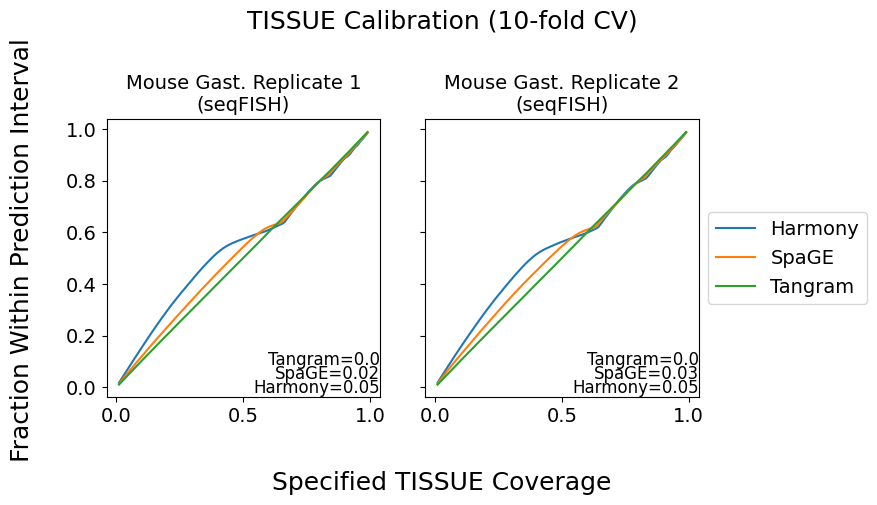

In [4]:
# all in one AVG calibration plot
dataset_names = ["Dataset1", "Dataset1Rep"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(9, 5))
for i, dataset_name in enumerate(dataset_names):
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict.pkl", 'rb')
    res_dict = pickle.load(pickleFile)

    for ki, key in enumerate(res_dict.keys()):
        # plot calibration curve
        axs[i].plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key])
        # compute and annotate AUC erro metric on plot
        error = round(measure_calibration_error(res_dict, key),2)
        axs[i].annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
        
    axs[i].set_title(dataset_mapper[dataset_name], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/REPLICATE_paneled_AVG_calibration_curves.pdf')
plt.show()

## Error and CCV correlations

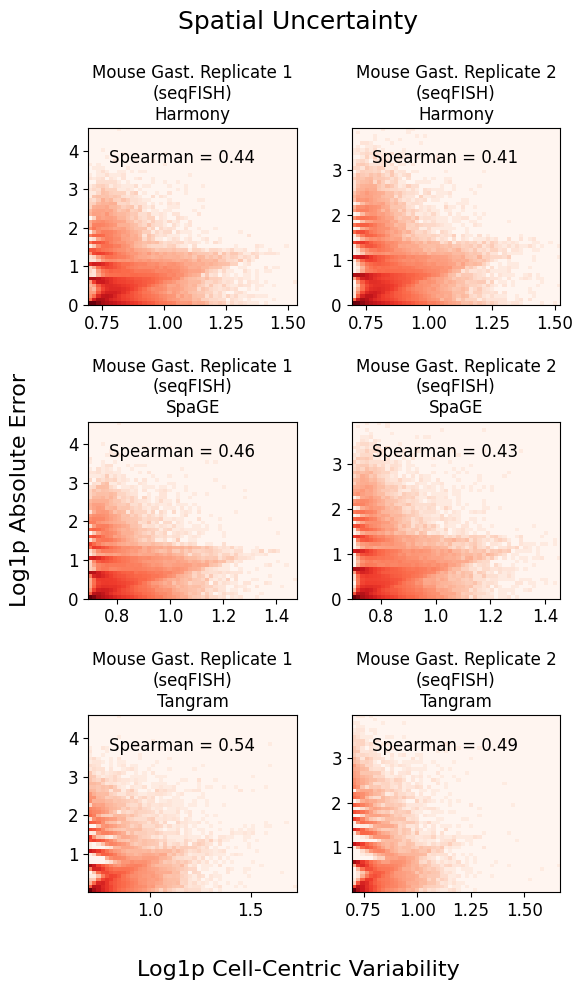

In [5]:
datasets = ["Dataset1", "Dataset1Rep"]
methods = ['knn', 'spage', 'tangram']


fig, axs = plt.subplots(nrows=len(methods), ncols=len(datasets), sharex=False, sharey=False, figsize=(6, 10))

for i, d in enumerate(datasets):
    
    # load dataset results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_NOCV.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_NOCV.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_NOCV")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
        
    # get dimensions
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # make histogram plot
        axs[j,i].set_title(f"{dataset_mapper[d]}\n{method_mapper[method]}")
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].tick_params(axis='both', which='minor', labelsize=12)
        
        rho, p = spearmanr(np.log1p(uncertainties), np.log1p(errs))
        heatmap, xedges, yedges = np.histogram2d(np.log1p(uncertainties), np.log1p(errs), bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[j,i].imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
        axs[j,i].annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=12)
        
fig.suptitle("Spatial Uncertainty", fontsize=18)
fig.supxlabel("Log1p Cell-Centric Variability", fontsize=16)
fig.supylabel("Log1p Absolute Error", fontsize=16)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_datasets/REPLICATE_uncertainty_error_correlations_log.pdf')
plt.show()

## Differential Gene Expression Analysis (Precision and Recall)

Relies on the `get_multi_ttest.py` outputs on both Dataset1 and Dataset1Rep data folders

In [6]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset1", "Dataset1Rep"]
conditions = ["celltype_mapped_refined", "celltype_mapped_refined"]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    condition=conditions[i]
    dataset_name=dataset_names[i]
    
    # read result anndata object
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/{dataset_name}_knn_spage_tangram_MI_TTEST.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):

            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other

            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add TISSUE testing results from var 
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # testing with measured expression
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # testing with predicted expression (baseline)
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# pickle dict
# with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "wb") as f:
#     pickle.dump(combined_stat_result_dict, f)

/tmp/ipykernel_12217/704963865.py:63: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_12217/704963865.py:64: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


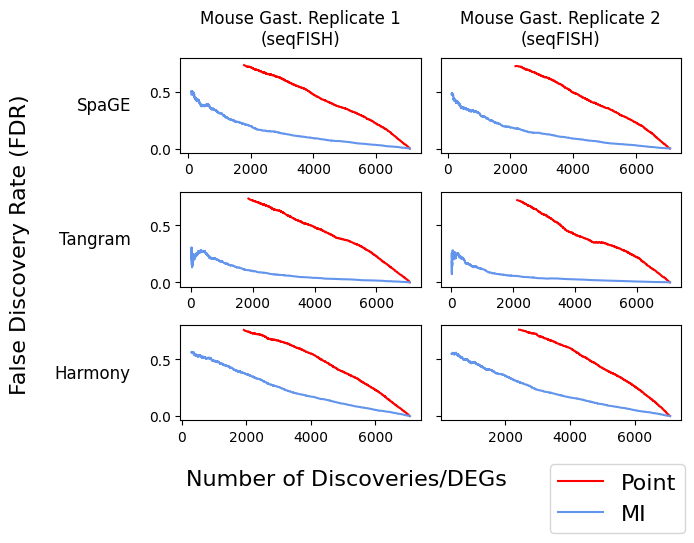

In [7]:
# Check FDR plot for the two replicates

dataset_names = ["Dataset1", "Dataset1Rep"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(7,5), sharex=False, sharey=True)
    
    
    
for j, dataset in enumerate(combined_stat_result_dict.keys()):
            
    for i, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            # get number of discoveries
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        axs[i, j].plot(num_pos_1, fdr_list_1, color='r', label="Predicted")
        axs[i, j].plot(num_pos_2, fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Point", "MI"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(combined_stat_result_dict.keys())]
rows = [method_mapper[m] for m in list(combined_stat_result_dict[dataset].keys())]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/REPLICATE_paneled_pvalue_numpositives_fdr_curves.pdf", bbox_inches='tight')
plt.show()

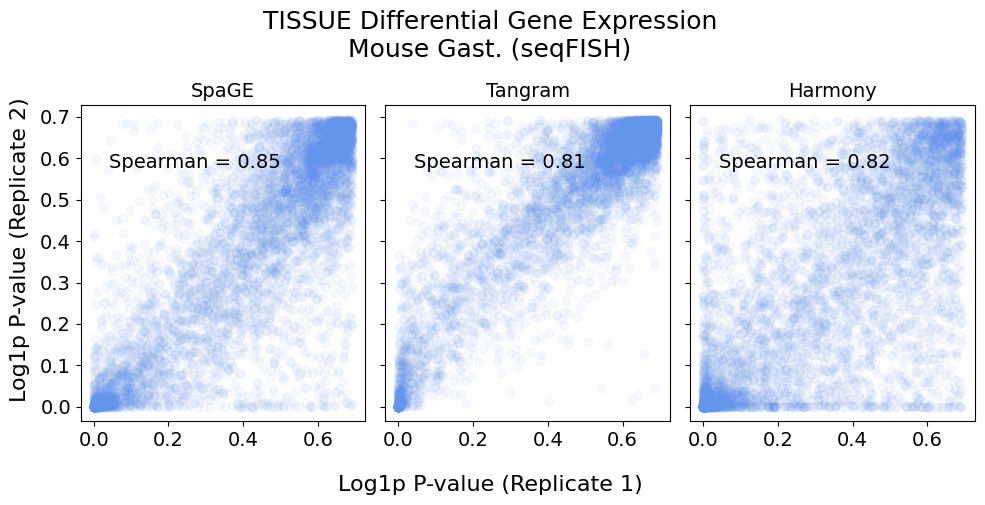

In [8]:
# Plots the p-values across Dataset1 and Dataset1Rep across all comparisons to visualize their correlations

dataset_names = ["Dataset1", "Dataset1Rep"]
ylab = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)
    
# Collect p-values for MI
dataset_agg_dict = {}

# loop dataset and methods    
for j, dataset in enumerate(combined_stat_result_dict.keys()):
    for i, method in enumerate(combined_stat_result_dict[dataset].keys()):
        
        if method not in dataset_agg_dict.keys():
            dataset_agg_dict[method] = {}
        
        # collect all comparisons
        agg_y = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_y = np.concatenate((agg_y, combined_stat_result_dict[dataset][method][g1][ylab]))
        
        if dataset not in dataset_agg_dict[method].keys():
            dataset_agg_dict[method][dataset] = agg_y

# Make plots
fig, axs = plt.subplots(1, 3, figsize=(10,5), sharex=False, sharey=True)

for i, method in enumerate(dataset_agg_dict.keys()):
    # scatter plot
    axs[i].scatter(np.log1p(dataset_agg_dict[method]["Dataset1"]),
                np.log1p(dataset_agg_dict[method]["Dataset1Rep"]),
                   label=method, alpha=0.05, c='cornflowerblue', rasterized=True)
    # get correlation
    rho,p = spearmanr(np.log1p(dataset_agg_dict[method]["Dataset1"]),
                np.log1p(dataset_agg_dict[method]["Dataset1Rep"]))
    # annotate plot
    axs[i].annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=14)
    axs[i].set_title(method_mapper[method], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)
        
fig.suptitle("TISSUE Differential Gene Expression\nMouse Gast. (seqFISH)",fontsize=18)
fig.supxlabel("Log1p P-value (Replicate 1)", fontsize=16)
fig.supylabel("Log1p P-value (Replicate 2)", fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/scpi_dgea/REPLICATE_Dataset1_pvalue_correlation.pdf', dpi=300, bbox_inches='tight')
plt.show()